# Supervisor (Multi-Agent)

In [2]:
#Library of LangAgent
#pip install LangAgent==0.3.1

In [2]:
# Import agents from all teams
#from LangAgent import *

c:\Users\kwadw.DESKTOP-T9BSTPE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
# * LIBRARIES

# Other packages
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

import operator
import functools
import os
import yaml

import yfinance 

from typing import Annotated, Sequence, TypedDict

from pprint import pprint
from IPython.display import Image
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import json
import time

In [5]:
# LangAgent Package
from LangAgent.supervisor import supervisor_chain
from LangAgent.research_team.agents import researcher, coder
from LangAgent.reporting_team.agents import interpreter


PATH_CREDENTIALS = 'credentials.yml'

# Load API keys
GROQ_API_KEY = yaml.safe_load(open('credentials.yml'))['groq']
os.environ['TAVILY_API_KEY'] = yaml.safe_load(open('credentials.yml'))['online']
os.environ['OPENWEATHERMAP_API_KEY'] = yaml.safe_load(open('credentials.yml'))['weather']
os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('credentials.yml'))['openai']

MODEL = "gpt-4o-mini"
llm = ChatOpenAI(model=MODEL)
os.environ['TAVILY_API_KEY'] = yaml.safe_load(open('credentials.yml'))['online']

## 1. Agents

In [7]:
# * Create Agent Supervisor

# Update subagent names
subagent_names = ["Researcher", "Coder", "Interpreter"]

subagent_descriptions = {
    "Researcher": "Skilled at conducting web-based research, retrieving accurate and relevant data from online resources. The Research Agent can also gather financial, technical, and domain-specific information from appropriate APIs and tools.",
    "Coder": "Proficient in generating, executing, and debugging Python code. The Coder Agent can analyze and manipulate data, create visualizations (using libraries like Matplotlib), and generate statistical reports. If needed, the Coder Agent can also perform basic data processing tasks and calculations.",
    "Interpreter": "Responsible for interpreting and explaining visual outputs (such as plots) generated by the **Coder_Agent**. The Plot Interpreter Agent will analyze the visualizations, identify patterns or trends, and provide a clear, concise interpretation of the results."
}

# Create a supervisor chain to manage the workflow
supervisor_agent = supervisor_chain(
    subagent_names=subagent_names, 
    llm=llm, 
    subagent_descriptions=subagent_descriptions, 
    completion_criteria="FINISH"
)

In [8]:
supervisor_agent

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'route_options': "['FINISH', 'Researcher', 'Coder', 'Interpreter']", 'subagent_names': 'Researcher, Coder, Interpreter'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="\n        You are a supervisor tasked with managing a conversation between the following workers: ['Researcher', 'Coder', 'Interpreter']. \n        Each worker has a specific role: \n        - Researcher: Skilled at conducting web-based research, retrieving accurate and relevant data from online resources. The Research Agent can also gather financial, technical, and domain-specific information from app

In [18]:
#for step in supervisor_agent.steps:
#    print(step)
#    if hasattr(step, 'prompt'):
#        print("System prompt:", step.prompt)

In [19]:
# * Research Agent

search = {
    'api_key': os.environ.get("TAVILY_API_KEY"),
    'max_results': 5,
    'search_depth': "advanced"
}
researcher_agent = researcher(llm=llm, tavily_search=search) ##try researcher.researcher(llm, tavily_search=search) if errors

In [20]:
researcher_agent

AgentExecutor(agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='\n                You are a high

In [21]:
# * Coder Agent

coder_agent = coder(llm=llm, system_prompt=None)

In [22]:
coder_agent

AgentExecutor(agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='\n            You are a highly p

In [23]:
# * Interpreter Agent

interpreter_agent = interpreter(llm=llm, interpreter_prompt=None)

In [24]:
interpreter_agent

PromptTemplate(input_variables=['code_output'], template="\n            You are a versatile data interpreter, and your role is to provide clear, insightful, and precise interpretations for various types of outputs, including visual plots, tables, descriptions, and results (whether or not they originate from Python execution).\n\n            Below is an output:\n\n            ```\n            {code_output}\n            ```\n\n            Please provide:\n\n            **1. Interpretation**:\n            - If it's a plot or graph (e.g., line graph, scatter plot, bar chart), explain the key insights, trends, patterns, or correlations. Highlight significant changes, relationships, and any anomalies.\n            - If it's a table or data (e.g., a DataFrame or report), explain the key statistics, patterns, outliers, and any other meaningful observations. Highlight relationships between the data.\n            - If it's another kind of result or description, explain the core findings, what th

## 2. LangGraph

In [25]:
# * LANGGRAPH

#   - NEW Skill: Annotated Sequences
class GraphState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    num_steps: Annotated[Sequence[int], operator.add]
    next: str

In [26]:
# * Create Supervisor Node
 
def supervisor_node(state):
    result = supervisor_agent.invoke(state)

    # Ensure only one route is returned
    if isinstance(result, dict) and 'next' in result:
        next_route = result['next']
        
        # If the next route is FINISH, we should terminate
        if next_route == 'FINISH':
            return {'next': 'FINISH', 'num_steps': 1}
        
        print(f"Next route selected: {next_route}")
        return {'next': next_route, 'num_steps': 1}
    
    # If there's no valid next route, end the workflow
    print("Invalid or missing next route, finishing workflow.")
    return {'next': 'FINISH', 'num_steps': 1}

In [27]:
# * Create Researcher Node

def research_node(state):
    
    result = researcher_agent.invoke(state)

    # Print the interpretation
    print(f"Research result: {result}")

    time.sleep(2)
    return {
        "messages": [HumanMessage(content=result["output"], name="Researcher")],
        'num_steps': 1
    }

In [28]:
# * Create Coder Node

def coder_node(state):
    
    result = coder_agent.invoke(state)

    time.sleep(2)
    return {
        "messages": [HumanMessage(content=result["output"], name="Coder")],
        'num_steps': 1
    }

In [29]:
# * Create Interpreter Node

def interpreter_node(state):
    # Pass the output from coder_agent to the plot interpreter
    code_output = state['messages'][-1].content  # Assuming the last message is the coder output
    interpretation = interpreter_agent.invoke({'code_output': code_output})
    
    # Print the interpretation
    print(f"Interpreter result: {interpretation}")
    
    return {
        "messages": [HumanMessage(content=interpretation, name="Interpreter")],
        'num_steps': 1,
        'next': 'FINISH'  # Signal workflow completion
    }

## 3. WorkFlow DAG

In [30]:
# * WORKFLOW DAG

# Create the workflow DAG
workflow = StateGraph(GraphState)

# Add nodes for researcher, coder, plot interpreter, and supervisor agents
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Interpreter", interpreter_node)  # Use Plot Interpreter node instead of Summarizer
workflow.add_node("supervisor", supervisor_node)

# Define the transitions between agents
workflow.add_edge("Researcher", "supervisor")  
workflow.add_edge("Coder", "supervisor")       
workflow.add_edge("Coder", "supervisor")  
workflow.add_edge("Interpreter", "supervisor")  

# Define conditional transitions based on the supervisor's decision
conditional_map = {
    'Researcher': 'Researcher',      # Supervisor sends to Researcher
    'Coder': 'Coder',                # Supervisor sends to Coder
    'Interpreter': 'Interpreter',  # Plot Interpreter is triggered after Coder
    'FINISH': END                    # Workflow ends when FINISH is reached
}

# Supervisor node
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Set the entry point to supervisor
workflow.set_entry_point("supervisor")

# Compile the workflow DAG
app = workflow.compile()

# * NEW: ADD CHECKPOINTER MEMORY
#app = workflow.compile(checkpointer=memory) 
# you can add memory to your langraph.

#First, import from langgraph.checkpoint.sqlite import SqliteSaver
#memory = SqliteSaver.from_conn_string(":memory:")
#memory

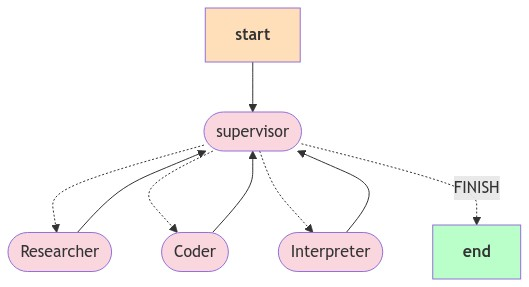

In [31]:
# Optionally display the graph of the workflow using Mermaid (or any other visualization library you have)
Image(app.get_graph().draw_mermaid_png())

## 4. Sample Question

Next route selected: Researcher
Research result: {'messages': [HumanMessage(content=" \nFind Ghana's GDP from 2002 to 2023. Make sure it is yearly. use a line graph\n")], 'num_steps': 1, 'next': 'Researcher', 'output': "I have gathered the GDP data for Ghana from 2002 to 2023. Below is the structured data in a table format, which can be visualized using a line graph.\n\nHere's the GDP data (in billion USD):\n\n| Year | GDP (Billion USD) |\n|------|-------------------|\n| 2002 | 4.07              |\n| 2003 | 4.36              |\n| 2004 | 5.06              |\n| 2005 | 5.56              |\n| 2006 | 6.55              |\n| 2007 | 8.05              |\n| 2008 | 8.66              |\n| 2009 | 9.27              |\n| 2010 | 12.07             |\n| 2011 | 14.70             |\n| 2012 | 16.10             |\n| 2013 | 17.57             |\n| 2014 | 18.88             |\n| 2015 | 17.87             |\n| 2016 | 15.71             |\n| 2017 | 17.10             |\n| 2018 | 20.22             |\n| 2019 | 68.34  

Python REPL can execute arbitrary code. Use with caution.


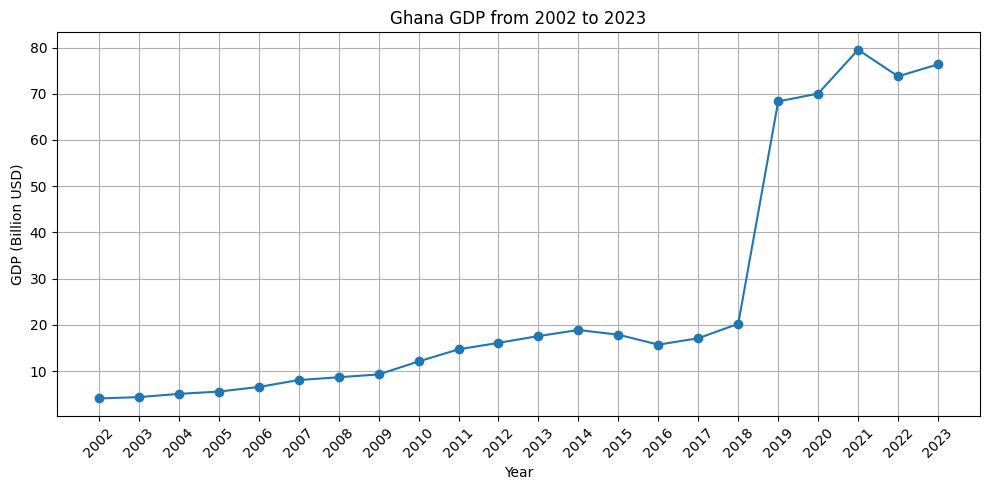

Next route selected: Interpreter
Interpreter result: ### 1. Interpretation:

The line graph visualizing Ghana's GDP from 2002 to 2023 reveals several key insights regarding the country's economic performance over the two-decade period:

- **Overall Growth Trend**: Ghana's GDP has shown a general upward trend from 2002 to 2023, with notable increases in several years. The GDP rose from approximately $4.07 billion in 2002 to a significant peak of about $79.52 billion in 2022.

- **Significant Growth Spurt**: The most remarkable increase occurred between 2017 and 2019, where GDP jumped from around $17.10 billion to $68.34 billion. This period highlights a substantial economic expansion, possibly reflecting improved economic policies, increased investments, or favorable external conditions.

- **Fluctuations**: Between 2015 and 2016, there was a notable decline in GDP, dropping from $17.87 billion to $15.71 billion. This dip may indicate economic challenges during those years, potentially 

In [32]:
# Example 1

question = """ 
Find Ghana's GDP from 2002 to 2023. Make sure it is yearly. use a line graph
"""
result = app.invoke(
    input = {"messages": [HumanMessage(content=question)]},
    config = {"recursion_limit": 10},
)

## 5. How It Works (From Researcher to Interpreter)

In [33]:
for message in result['messages']:
    if message.name:
        print(f"Name: {message.name}")
    print(f"Content: {message.content}")
    print("---")
    print()

Content:  
Find Ghana's GDP from 2002 to 2023. Make sure it is yearly. use a line graph

---

Name: Researcher
Content: I have gathered the GDP data for Ghana from 2002 to 2023. Below is the structured data in a table format, which can be visualized using a line graph.

Here's the GDP data (in billion USD):

| Year | GDP (Billion USD) |
|------|-------------------|
| 2002 | 4.07              |
| 2003 | 4.36              |
| 2004 | 5.06              |
| 2005 | 5.56              |
| 2006 | 6.55              |
| 2007 | 8.05              |
| 2008 | 8.66              |
| 2009 | 9.27              |
| 2010 | 12.07             |
| 2011 | 14.70             |
| 2012 | 16.10             |
| 2013 | 17.57             |
| 2014 | 18.88             |
| 2015 | 17.87             |
| 2016 | 15.71             |
| 2017 | 17.10             |
| 2018 | 20.22             |
| 2019 | 68.34             |
| 2020 | 70.04             |
| 2021 | 79.52             |
| 2022 | 73.77             |
| 2023 | 76.37         

In [34]:
response_text = "## Result:\n\n"
for message in result['messages']:
    if message.name:
        response_text += f"### **Team Member:** {message.name}\n\n"
        response_text += f"\n\n{message.content}\n"
    response_text += "---\n"

In [36]:
print(response_text)

## Result:

---
### **Team Member:** Researcher



I have gathered the GDP data for Ghana from 2002 to 2023. Below is the structured data in a table format, which can be visualized using a line graph.

Here's the GDP data (in billion USD):

| Year | GDP (Billion USD) |
|------|-------------------|
| 2002 | 4.07              |
| 2003 | 4.36              |
| 2004 | 5.06              |
| 2005 | 5.56              |
| 2006 | 6.55              |
| 2007 | 8.05              |
| 2008 | 8.66              |
| 2009 | 9.27              |
| 2010 | 12.07             |
| 2011 | 14.70             |
| 2012 | 16.10             |
| 2013 | 17.57             |
| 2014 | 18.88             |
| 2015 | 17.87             |
| 2016 | 15.71             |
| 2017 | 17.10             |
| 2018 | 20.22             |
| 2019 | 68.34             |
| 2020 | 70.04             |
| 2021 | 79.52             |
| 2022 | 73.77             |
| 2023 | 76.37             |

### Visualization
To visualize this data, you can use the foll